In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import keras
import numpy
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
import keras
import numpy
from keras.preprocessing.image import ImageDataGenerator

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In the following code, we are loading only 32 images at once into memory and performing all the preprocessing operations on loaded images. The flow_from_directory loads a defined set of images from the location of images, instead of loading all images at once into memory.

- train_generator contains training set
- val_generator contains validation set

In [4]:
train_data = '../input/state-farm-distracted-driver-detection/imgs/train'
test_data = '../input/state-farm-distracted-driver-detection/imgs/test'
train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [5]:
from PIL import Image

ac_labels=  ["c0: safe driving",
"c1: texting - right",
"c2: talking on the phone - right",
"c3: texting - left",
"c4: talking on the phone - left",
"c5: operating the radio",
"c6: drinking",
"c7: reaching behind",
"c8: hair and makeup",
"c9: talking to passenger"]


In [6]:
imgs, labels = next(train_generator)

## Dataset Exploration
- Following code block explores and reveals the dataset

In [7]:
import functools

def list_counts(start_dir):
    lst = sorted(os.listdir(start_dir))
    out = [(fil, len(os.listdir( os.path.join(start_dir, fil)))) for fil in lst if os.path.isdir(os.path.join(start_dir,fil))]
    return out

out = list_counts(train_data)
labels, counts = zip(*out)
print("Total number of images : ",functools.reduce(lambda a,b : a+b, counts))
out

Total number of images :  22424


[('c0', 2489),
 ('c1', 2267),
 ('c2', 2317),
 ('c3', 2346),
 ('c4', 2326),
 ('c5', 2312),
 ('c6', 2325),
 ('c7', 2002),
 ('c8', 1911),
 ('c9', 2129)]

## Data Visualization
Following code block. displays images and their respective labels of training/ validation dataset

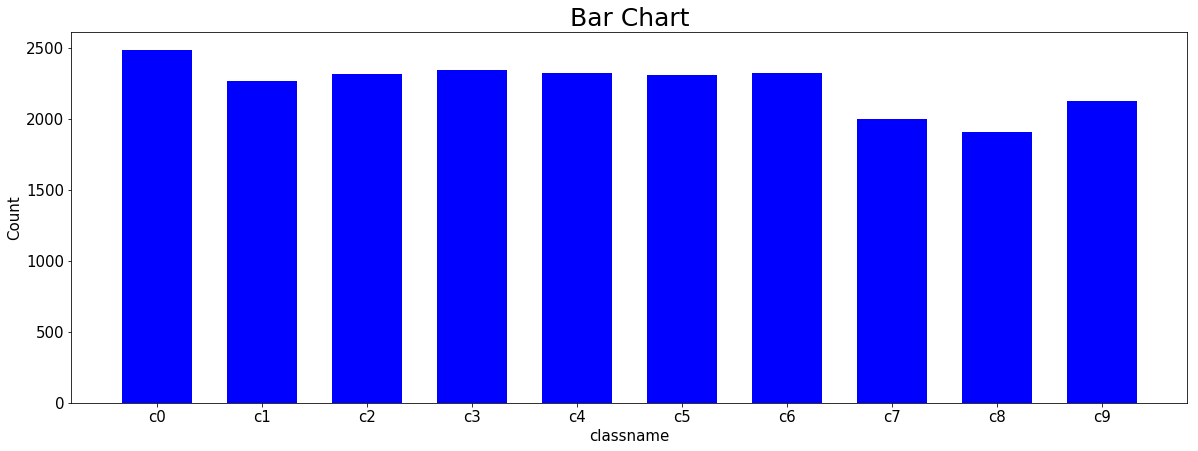

Label :  c0: safe driving


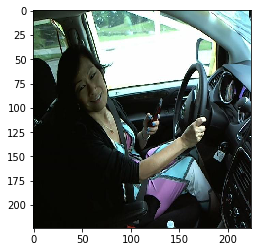

In [8]:

import matplotlib.pyplot as plt
import pandas as pd
# Pretty display for notebooks
%matplotlib inline


y = np.array(counts)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()



def showImages(imgs ,inlabels=None, single=True):
    if single:
        aim = (imgs * 255 ).astype(np.uint8)
        img = Image.fromarray(aim)
        if labels is not None:
            print("Label : ", ac_labels[np.argmax(inlabels)])
        plt.imshow(img)
        plt.show()
    else:
        for i,img in enumerate(imgs):
            lbl = None
            if inlabels is not None:
                lbl = labels[i]
            showImages(img, lbl)

ind = 1
showImages(imgs[:ind], inlabels=labels[:ind], single = False)


---
<a id="step2"></a>
##  Train a CNN with Transfer Learning (Using Fine-tuned VGG19 Model)

- In the following steps, we are going to load a VGG19 model, without top Fully connected layers, with its trained weights(imagenet)
- Then we are going add Fully Connected Layers on top of MaxPooling2D layer.
- Leaving the last 2-3 layers, the weights of all other layers of VGG19 have been freezed

In [9]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.applications import VGG19

In [10]:
pretrained_model = VGG19( input_shape = (224,224,3) , weights = 'imagenet' , include_top = False)
for layer in pretrained_model.layers[:19]:
        layer.trainable = False

model = Sequential([
        pretrained_model,
        MaxPooling2D((2,2) , strides = 2),
        Flatten(),
        Dense(10 , activation='softmax')])
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                46090     
Total params: 20,070,474
Trainable params: 4,765,706
Non-trainable params: 15,304,768
_________________________________________________________________


### (IMPLEMENTATION) Train the Model

The model is trained in the code cell below. Model checkpointing is used to save the model that attains the best validation loss.


In [11]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)

history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator),
                    epochs=5,
                   validation_data = val_generator,
                   validation_steps=len(val_generator),
                    callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
561/561 [==============================] - 221s 395ms/step - loss: 0.5183 - acc: 0.8258 - val_loss: 0.1107 - val_acc: 0.9663

Epoch 00001: val_loss improved from inf to 0.11066, saving model to best_model.h5
Epoch 2/5
561/561 [==============================] - 177s 315ms/step - loss: 0.0713 - acc: 0.9797 - val_loss: 0.0631 - val_acc: 0.9810

Epoch 00002: val_loss improved from 0.11066 to 0.06313, saving model to best_model.h5
Epoch 3/5
561/561 [==============================] - 177s 315ms/step - loss: 0.0427 - acc: 0.9870 - val_loss: 0.0925 - val_acc: 0.9719

Epoch 00003: val_loss did not improve from 0.06313
Epoch 4/5
561/561 [==============================] - 175s 312ms/step - loss: 0.0306 - acc: 0.9904 - val_loss: 0.0864 - val_acc: 0.9768

Epoch 00004: val_loss did not improve from 0.06313
Epoch 5/5
561/561 [==============================] - 175s 312ms/step - loss: 0.0347 - acc: 0.9902 - val_loss: 0.0808 - val_acc: 0.9784

Ep

- In the following code block, we are plotting the loss value of training and validation to see whether the model is learning or not

In [12]:
print("Max Training Accuracy : " , max(history.history['acc']) * 100 , "%")
print("Max Testing Accuracy : " , max(history.history['val_acc']) * 100 , "%")

Max Training Accuracy :  99.04140890598005 %
Max Testing Accuracy :  98.1031019861638 %


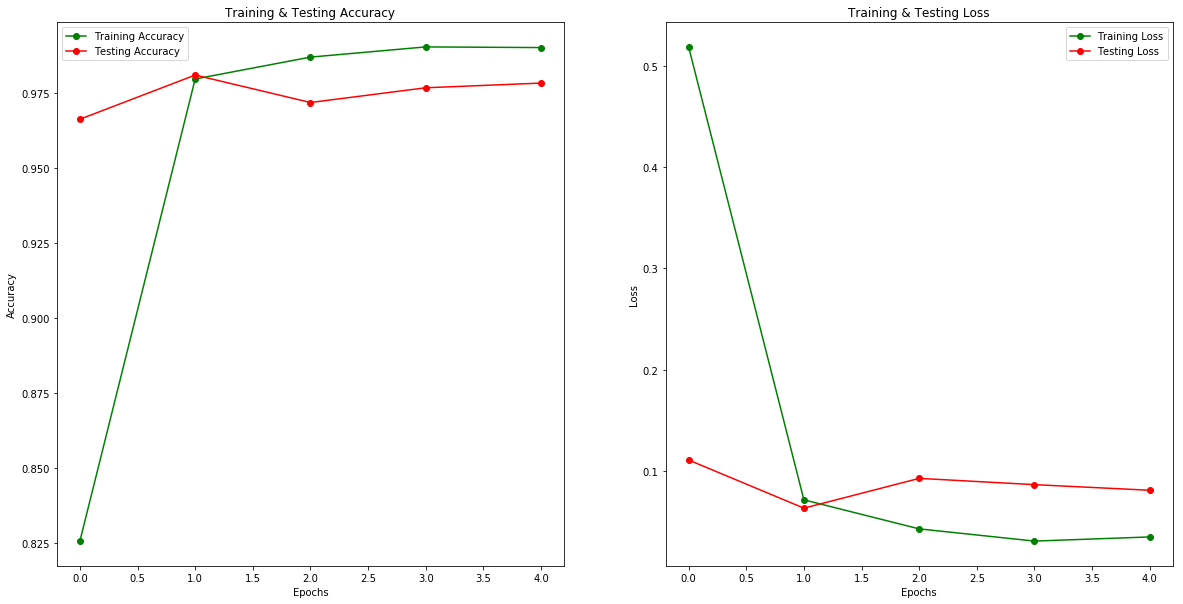

In [18]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [55]:
predictions = model.predict_generator(val_generator , steps = len(val_generator))
predictions[:5]

array([[1.37278305e-13, 1.37767145e-07, 4.07032367e-19, 9.99999881e-01,
        1.03670114e-10, 4.58941207e-19, 5.64703896e-17, 2.70280978e-25,
        5.34462526e-20, 2.19239062e-14],
       [2.54696920e-06, 9.99895334e-01, 6.50969412e-07, 4.61806763e-07,
        8.08514451e-05, 4.30080242e-11, 1.97807785e-05, 1.06638934e-10,
        1.10555554e-07, 3.24095652e-07],
       [3.09507996e-12, 4.20622957e-20, 5.57330825e-19, 1.26198482e-10,
        1.00000000e+00, 3.88168733e-11, 7.25348254e-11, 3.72302967e-21,
        3.24348777e-11, 1.81532740e-11],
       [1.15771996e-10, 7.96440675e-21, 6.65201867e-15, 3.26446091e-14,
        1.00000000e+00, 6.92157123e-15, 2.52923186e-11, 2.04809685e-23,
        2.26105679e-11, 4.94526607e-11],
       [3.28819844e-17, 4.31021829e-10, 3.51665422e-15, 3.04036719e-17,
        7.30305031e-14, 1.41029194e-11, 7.89802179e-09, 9.99976039e-01,
        1.96635753e-07, 2.37301356e-05]], dtype=float32)

In [56]:
y_val = val_generator.labels
y_val

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [92]:
validation_x = []
for i in range( val_generator.__len__() ):
    validation_x.extend(
        val_generator.__getitem__( i )[0] 
        )

In [93]:
np.array(validation_x).shape

(4481, 224, 224, 3)

In [97]:
y_pred = model.predict_classes(np.array(validation_x))
y_pred

array([5, 7, 0, ..., 4, 4, 0])

In [98]:
validation_y = []
for i in range( val_generator.__len__() ):
    validation_y.extend(
        val_generator.__getitem__( i )[1] 
        )

In [106]:
np.array(validation_y).shape

(4481, 10)

In [102]:
y_val = np.argmax(validation_y , axis = 1)
y_val

array([5, 7, 0, ..., 4, 4, 0])

In [107]:
from sklearn.metrics import classification_report,confusion_matrix

In [108]:
print(classification_report(y_val, y_pred, target_names = ac_labels))

                                  precision    recall  f1-score   support

                c0: safe driving       0.94      0.98      0.96       497
             c1: texting - right       0.98      0.99      0.99       453
c2: talking on the phone - right       1.00      0.99      0.99       463
              c3: texting - left       1.00      0.97      0.99       469
 c4: talking on the phone - left       0.97      1.00      0.99       465
         c5: operating the radio       1.00      0.92      0.96       462
                    c6: drinking       1.00      0.99      0.99       465
             c7: reaching behind       0.99      0.99      0.99       400
             c8: hair and makeup       0.99      0.94      0.97       382
        c9: talking to passenger       0.92      1.00      0.95       425

                       micro avg       0.98      0.98      0.98      4481
                       macro avg       0.98      0.98      0.98      4481
                    weighted avg    

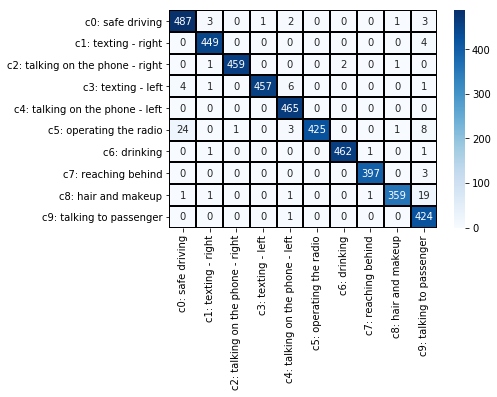

In [109]:
import seaborn as sns
plt.figure(figsize = (10,10))
cm = confusion_matrix(y_val,y_pred)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ac_labels , yticklabels = ac_labels)